In [ ]:
%matplotlib inline


# Comparing different clustering algorithms on toy datasets

This example shows characteristics of different
clustering algorithms on datasets that are "interesting"
but still in 2D. With the exception of the last dataset,
the parameters of each of these dataset-algorithm pairs
has been tuned to produce good clustering results. Some
algorithms are more sensitive to parameter values than
others.

The last dataset is an example of a 'null' situation for
clustering: the data is homogeneous, and there is no good
clustering. For this example, the null dataset uses the
same parameters as the dataset in the row above it, which
represents a mismatch in the parameter values and the
data structure.

While these examples give some intuition about the
algorithms, this intuition might not apply to very high
dimensional data.


### My Notes
1. There are 6 datasets.
2. The points with same color belong to same cluster
3. Ideally, we want the points close to each other to belong to the same cluster (having same color).
4. The differently colored clusters should be well separated.  

In [1]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice


def create_toy_data_clusters():
    np.random.seed(0)

    # ============
    # Generate datasets. We choose the size big enough to see the scalability
    # of the algorithms, but not too big to avoid too long running times
    # ============
    n_samples = 1500
    noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
    noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
    blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
    no_structure = np.random.rand(n_samples, 2), None

    # Anisotropicly distributed data
    random_state = 170
    X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
    transformation = [[0.6, -0.6], [-0.4, 0.8]]
    X_aniso = np.dot(X, transformation)
    aniso = (X_aniso, y)

    # blobs with varied variances
    varied = datasets.make_blobs(
        n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
    )
    
    default_base = {
        "quantile": 0.3,
        "eps": 0.3,
        "damping": 0.9,
        "preference": -200,
        "n_neighbors": 10,
        "n_clusters": 3,
        "min_samples": 20,
        "xi": 0.05,
        "min_cluster_size": 0.1,
    }
    
    cluster_datasets = [
        (
            noisy_circles,
            {
                "damping": 0.77,
                "preference": -240,
                "quantile": 0.2,
                "n_clusters": 2,
                "min_samples": 20,
                "xi": 0.25,
            },
        ),
        (noisy_moons, {"damping": 0.75, "preference": -220, "n_clusters": 2}),
        (
            varied,
            {
                "eps": 0.18,
                "n_neighbors": 2,
                "min_samples": 5,
                "xi": 0.035,
                "min_cluster_size": 0.2,
            },
        ),
        (
            aniso,
            {
                "eps": 0.15,
                "n_neighbors": 2,
                "min_samples": 20,
                "xi": 0.1,
                "min_cluster_size": 0.2,
            },
        ),
        (blobs, {}),
        (no_structure, {}),
    ]
    return default_base, cluster_datasets

def run_clustering_algos(default_base, datasets):
    plot_num = 1
    # ============
    # Set up cluster parameters
    # ============
    plt.figure(figsize=(9 * 2 + 3, 13))
    plt.subplots_adjust(
        left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
    )


    for i_dataset, (dataset, algo_params) in enumerate(datasets):
        # update parameters with dataset-specific values
        params = default_base.copy()
        params.update(algo_params)

        X, y = dataset

        # normalize dataset for easier parameter selection
        X = StandardScaler().fit_transform(X)

        # estimate bandwidth for mean shift
        bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

        # connectivity matrix for structured Ward
        connectivity = kneighbors_graph(
            X, n_neighbors=params["n_neighbors"], include_self=False
        )
        # make connectivity symmetric
        connectivity = 0.5 * (connectivity + connectivity.T)

        # ============
        # Create cluster objects
        # ============
        ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
        two_means = cluster.MiniBatchKMeans(n_clusters=params["n_clusters"])
        ward = cluster.AgglomerativeClustering(
            n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
        )
        spectral = cluster.SpectralClustering(
            n_clusters=params["n_clusters"],
            eigen_solver="arpack",
            affinity="nearest_neighbors",
        )
        dbscan = cluster.DBSCAN(eps=params["eps"])
        optics = cluster.OPTICS(
            min_samples=params["min_samples"],
            xi=params["xi"],
            min_cluster_size=params["min_cluster_size"],
        )
        affinity_propagation = cluster.AffinityPropagation(
            damping=params["damping"], preference=params["preference"], random_state=0
        )
        average_linkage = cluster.AgglomerativeClustering(
            linkage="average",
            affinity="cityblock",
            n_clusters=params["n_clusters"],
            connectivity=connectivity,
        )
        birch = cluster.Birch(n_clusters=params["n_clusters"])
        gmm = mixture.GaussianMixture(
            n_components=params["n_clusters"], covariance_type="full"
        )

        clustering_algorithms = (
            ("MiniBatch\nKMeans", two_means),
            ("Affinity\nPropagation", affinity_propagation),
            ("MeanShift", ms),
            ("Spectral\nClustering", spectral),
            ("Ward", ward),
            ("Agglomerative\nClustering", average_linkage),
            ("DBSCAN", dbscan),
            ("OPTICS", optics),
            ("BIRCH", birch),
            ("Gaussian\nMixture", gmm),
        )

        for name, algorithm in clustering_algorithms:
            t0 = time.time()

            # catch warnings related to kneighbors_graph
            with warnings.catch_warnings():
                warnings.filterwarnings(
                    "ignore",
                    message="the number of connected components of the "
                    + "connectivity matrix is [0-9]{1,2}"
                    + " > 1. Completing it to avoid stopping the tree early.",
                    category=UserWarning,
                )
                warnings.filterwarnings(
                    "ignore",
                    message="Graph is not fully connected, spectral embedding"
                    + " may not work as expected.",
                    category=UserWarning,
                )
                algorithm.fit(X)

            t1 = time.time()
            if hasattr(algorithm, "labels_"):
                y_pred = algorithm.labels_.astype(int)
            else:
                y_pred = algorithm.predict(X)

            plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
            if i_dataset == 0:
                plt.title(name, size=18)

            colors = np.array(
                list(
                    islice(
                        cycle(
                            [
                                "#377eb8",
                                "#ff7f00",
                                "#4daf4a",
                                "#f781bf",
                                "#a65628",
                                "#984ea3",
                                "#999999",
                                "#e41a1c",
                                "#dede00",
                            ]
                        ),
                        int(max(y_pred) + 1),
                    )
                )
            )
            # add black color for outliers (if any)
            colors = np.append(colors, ["#000000"])
            plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

            plt.xlim(-2.5, 2.5)
            plt.ylim(-2.5, 2.5)
            plt.xticks(())
            plt.yticks(())
            plt.text(
                0.99,
                0.01,
                ("%.2fs" % (t1 - t0)).lstrip("0"),
                transform=plt.gca().transAxes,
                size=15,
                horizontalalignment="right",
            )
            plot_num += 1

    plt.show()

### Creating toy data clusters

In [2]:
default_base, cluster_datasets = create_toy_data_clusters()

### Running the clustering algorithms

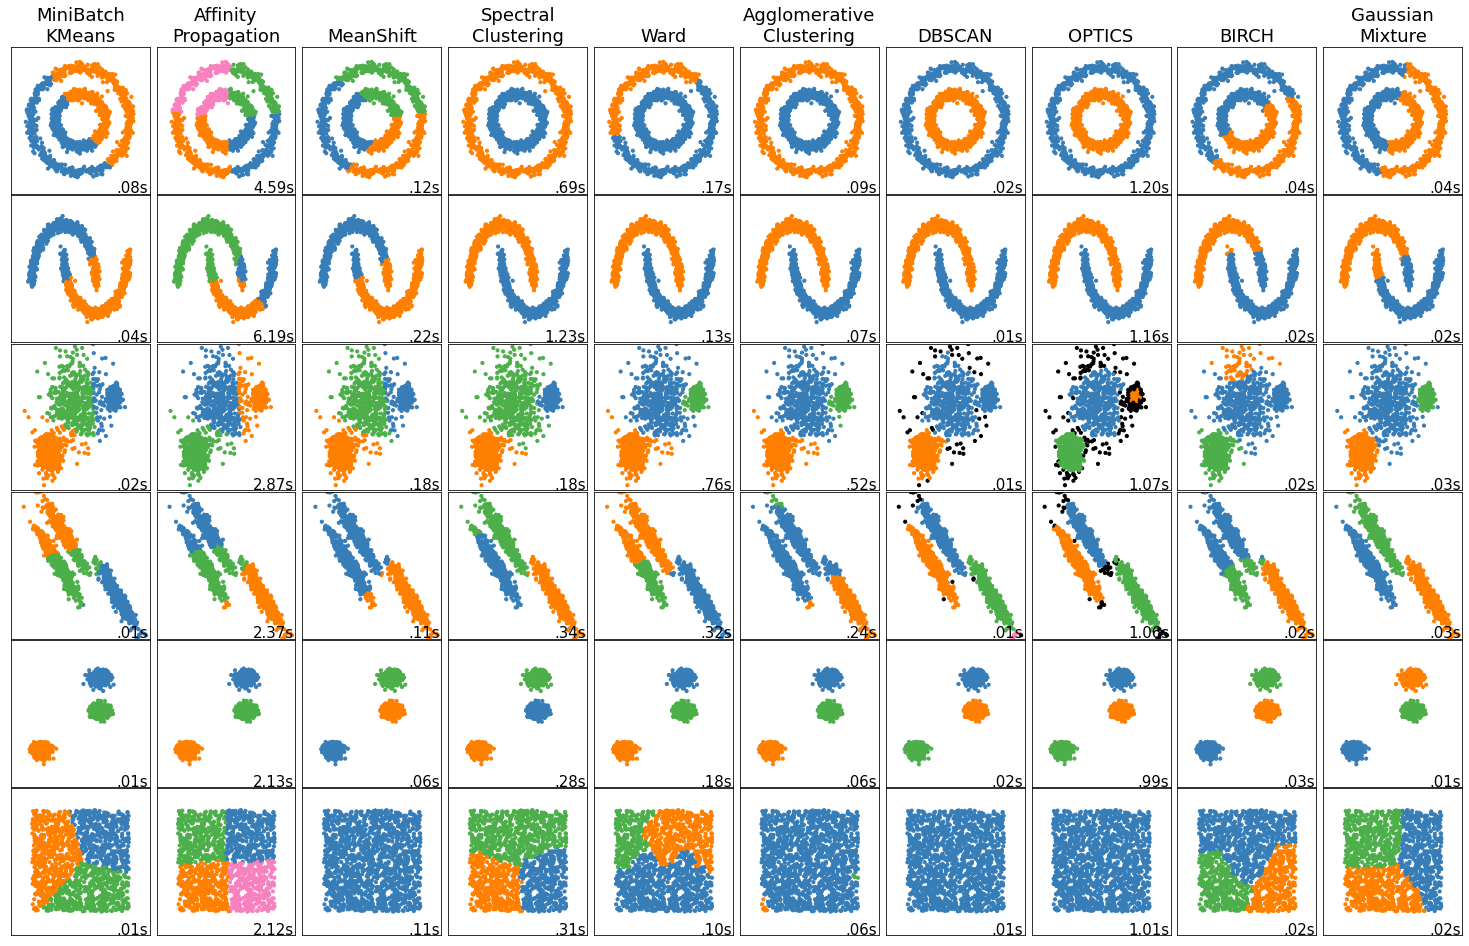

In [3]:
run_clustering_algos(default_base, cluster_datasets)

## `cGLAD` : Consensus based clustering
1. Transform the data by adjusting for the consensus among the features.  
2. Run off-the-shelf clustering algorithms.  

In [13]:
_X = cluster_datasets[0][0][0]

In [48]:
from uGLAD import main as uG
from sklearn.covariance import GraphicalLassoCV
import sys
from scipy.linalg import expm

def cGLAD_transform(X, ALGO='uGLAD'):
    """Adjust the input data X to capture consensus 
    among its column features.
    
    Args:
        X (2D np.array): The input data X with M samples 
            and D features
        ALGO (str): uGLAD/BCD to obtain the precision matrix
            
    Returns:
        Xc (2D np.array): The transformed consensus data Xc
            with M samples and D features
    """
    if ALGO == 'uGLAD':
        # Initialize the model
        model = uG.uGLAD_GL()  

        # Fit to the data
        model.fit(
            X,
            centered=False,
            epochs=400,
            lr=0.005,
            INIT_DIAG=0,
            L=15,
            verbose=True, 
            k_fold=0,  # Direct mode
            mode='direct'
        )  
    elif ALGO == 'BCD':
        model = GraphicalLassoCV().fit(X)
    else:
        print(f'Enter a valid algorithm for graphical lasso, currently entered {ALGO}')
        sys.exit(0)

    Xc = np.matmul(X, expm(model.precision_))
    return Xc
    
def cGLAD_cluster():
    pass

In [49]:
from copy import deepcopy

def prep_data_cGLAD(cluster_datasets):
    cGLAD_datasets = []
    for cd in cluster_datasets:
        _X = cd[0][0]  # extract X
        _Xc = cGLAD_transform(_X, ALGO='BCD')  # Get consensus Xc
        
        transformed = []  # get the copy for cGLAD data
        for i, c in enumerate(cd):
            if i == 0:
                # append the tuple (X, y)
                transformed.append((_Xc.copy(), c[1]))
            elif i==1:
                transformed.append(c) # append the dict 
        cGLAD_datasets.append(tuple(transformed))
    return cGLAD_datasets

In [50]:
cGLAD_datasets = prep_data_cGLAD(cluster_datasets)

/home/harshx/anaconda3/envs/uGLAD/lib/python3.8/site-packages/sklearn/cluster/_affinity_propagation.py:250: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  warnings.warn(


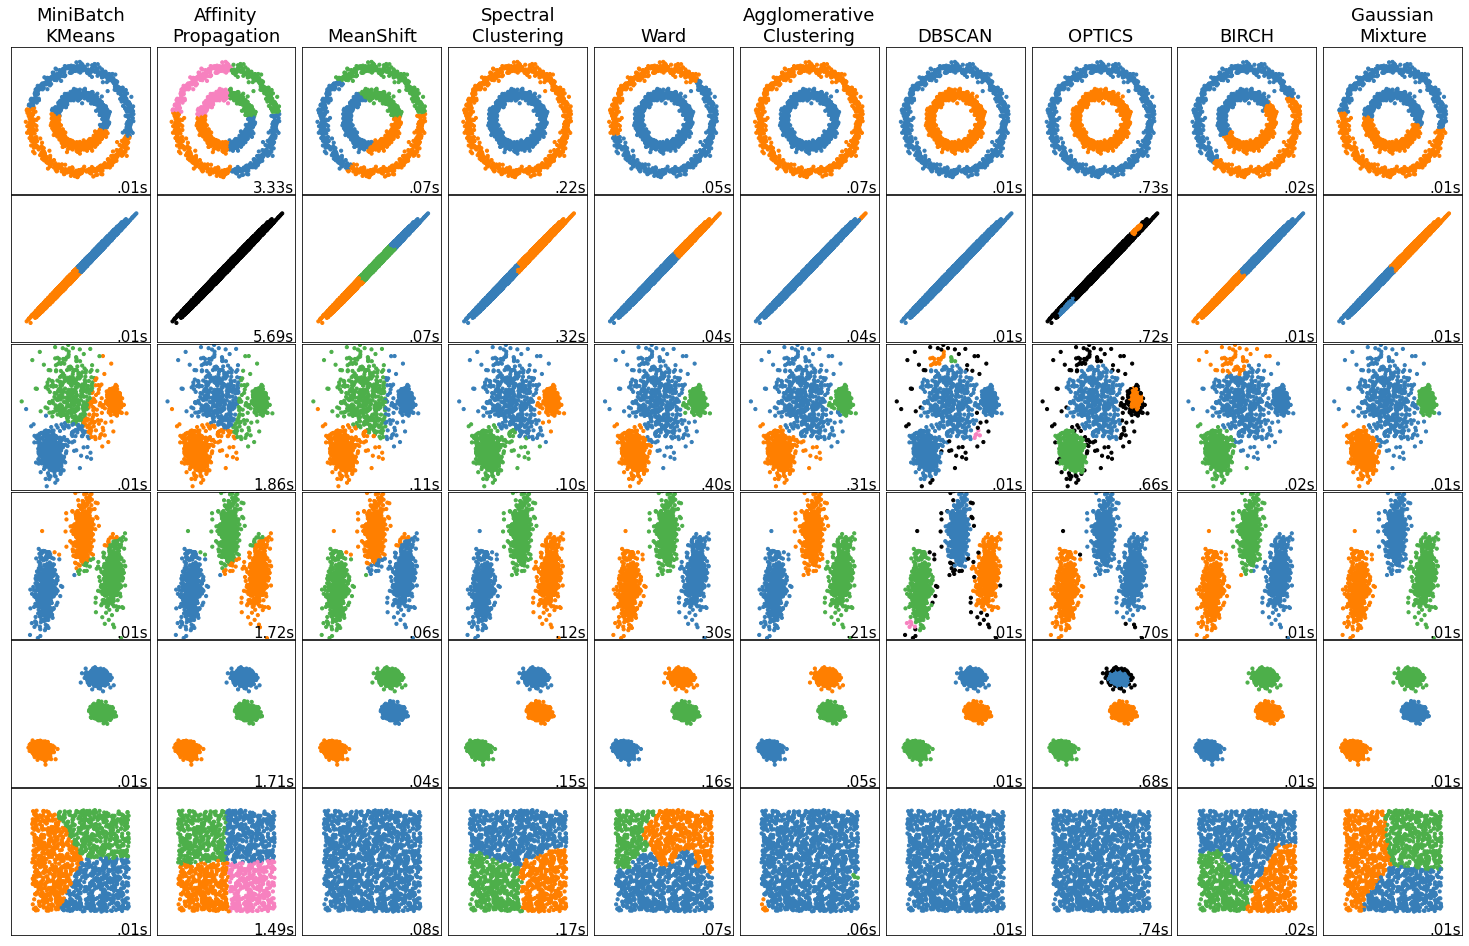

In [51]:
run_clustering_algos(default_base, cGLAD_datasets)

In [52]:
cGLAD_datasets

[((array([[-16.49378927, -16.9743912 ],
          [ 22.65921423,   4.6493294 ],
          [ 13.33836225,  -0.14617012],
          ...,
          [ -8.39744239,  -8.69779699],
          [  0.41836044, -22.95954512],
          [ 22.22962875, -14.54722091]]),
   array([0, 0, 1, ..., 1, 0, 0])),
  {'damping': 0.77,
   'preference': -240,
   'quantile': 0.2,
   'n_clusters': 2,
   'min_samples': 20,
   'xi': 0.25}),
 ((array([[-11.2945987 , -39.5999721 ],
          [ 63.60267104, 193.17269566],
          [ 69.70564826, 201.48216209],
          ...,
          [ 56.45318422, 148.11563824],
          [-11.15546102, -39.74842021],
          [ 28.62236072,  85.61791406]]),
   array([1, 0, 0, ..., 1, 1, 1])),
  {'damping': 0.75, 'preference': -220, 'n_clusters': 2}),
 ((array([[ -6.8650773 ,   2.4941955 ],
          [ -8.32322221,   1.95613666],
          [-11.06306889,  -8.15307023],
          ...,
          [  1.83183518,  -0.43069815],
          [  0.8019844 ,   0.6659921 ],
          [  2.069

In [53]:
cluster_datasets

[((array([[-0.67799938, -0.69875698],
          [ 0.93143746,  0.19139133],
          [ 0.54829131, -0.00601715],
          ...,
          [-0.34518816, -0.35804797],
          [ 0.01719727, -0.94513802],
          [ 0.91377877, -0.59884164]]),
   array([0, 0, 1, ..., 1, 0, 0])),
  {'damping': 0.77,
   'preference': -240,
   'quantile': 0.2,
   'n_clusters': 2,
   'min_samples': 20,
   'xi': 0.25}),
 ((array([[ 0.49627131, -0.34275349],
          [-0.16629956,  0.92234209],
          [ 0.71895601,  0.66529038],
          ...,
          [ 1.90950927,  0.02989686],
          [ 0.54623069, -0.36003133],
          [ 0.04090016,  0.37069297]]),
   array([1, 0, 0, ..., 1, 1, 1])),
  {'damping': 0.75, 'preference': -220, 'n_clusters': 2}),
 ((array([[ -6.11119721,   1.47153062],
          [ -7.49665361,   0.9134251 ],
          [-10.84489837,  -7.55352273],
          ...,
          [  1.64990343,  -0.20117787],
          [  0.79230661,   0.60868888],
          [  1.91226342,   0.25327399]]),
